<a href="https://colab.research.google.com/github/theQuert/inlpfun/blob/master/Demo/Analysis_of_Covid19_Vaccination_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%%capture
!pip3 install transformers

In [4]:
import re
import numpy as np
import pandas as pd
import os, json
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%%capture
!pip3 install spacy cssselect
!python3 -m spacy download en_core_web_sm
!pip3 install sentence-transformers 
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import urllib
from urllib import request
import requests
import time 
import datetime
import random
from bs4 import BeautifulSoup
from transformers import pipeline, BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
en_stop = set(nltk.corpus.stopwords.words('english'))
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print(f'We are using "{device}"')

We are using "cuda"


In [7]:
%cd /content/drive/MyDrive/Colab Notebooks/NCCU_BD21

/content/drive/MyDrive/Colab Notebooks/NCCU_BD21


#### Training (ac)

In [8]:
df = pd.read_csv('tweet_dataset.csv')

In [9]:
df.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier a...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,We want to trade with someone who has Houston...,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


We only extract `text` and `new_sentiment`

In [10]:
train = pd.DataFrame()
train['text'] = df['text']
train['Sentiment'] = df['new_sentiment']

Drop NaN

In [11]:
train = train.dropna()
train.isnull().sum()

text         0
Sentiment    0
dtype: int64

In [12]:
train['Sentiment'] = train['Sentiment'].replace(['negative', 'neutral', 'positive'], [0, 1, 2])

In [13]:
train.head()

,text,Sentiment
1,Layin n bed with a headache ughhhh...waitin o...,0
2,Funeral ceremony...gloomy friday...,0
3,wants to hang out with friends SOON!,2
4,We want to trade with someone who has Houston...,1
5,Re-pinging : why didn`t you go to prom? BC my ...,0


#### Import BERT Tokenizer

In [8]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

#### Preprocessing (ac)

In [15]:
for tweet in train['text']:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)
    max_len = max(0, len(input_ids))

print('Max sequence length: ', max_len)

Max sequence length:  33


In [16]:
input_ids = []
attention_masks = []

for sent in train['text']:
    encoded_dict = tokenizer.encode_plus(
        sent,
        # padding=True, 
        truncation=True,
        max_length=110,
        pad_to_max_length=True,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train['Sentiment'].tolist())

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#### Datasets and DataLoaders (ac)

In [17]:
# Create the dataset wrapping tensors 
# input_ids, attention_masks, labels
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size = batch_size
)

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels = 3, 
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

#### Optimizer and Scheduler (ac)

In [20]:
from transformers import get_linear_schedule_with_warmup
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps=1e-8)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [23]:
import time, datetime, random

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### Training Loop (ac)

In [24]:
epochs=5

model.to(device)

training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids = None,
                       attention_mask = b_attention_mask,
                       labels = b_labels,
                       return_dict=True)
        
        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print(" Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Training epcoh took: {:}".format(training_time))


======== Epoch 1 / 5 ========
Training...
  Batch     0  of    882.    Elapsed: 0:00:00.
  Batch    40  of    882.    Elapsed: 0:00:08.
  Batch    80  of    882.    Elapsed: 0:00:16.
  Batch   120  of    882.    Elapsed: 0:00:24.
  Batch   160  of    882.    Elapsed: 0:00:32.
  Batch   200  of    882.    Elapsed: 0:00:40.
  Batch   240  of    882.    Elapsed: 0:00:48.
  Batch   280  of    882.    Elapsed: 0:00:56.
  Batch   320  of    882.    Elapsed: 0:01:04.
  Batch   360  of    882.    Elapsed: 0:01:12.
  Batch   400  of    882.    Elapsed: 0:01:20.
  Batch   440  of    882.    Elapsed: 0:01:28.
  Batch   480  of    882.    Elapsed: 0:01:36.
  Batch   520  of    882.    Elapsed: 0:01:45.
  Batch   560  of    882.    Elapsed: 0:01:53.
  Batch   600  of    882.    Elapsed: 0:02:01.
  Batch   640  of    882.    Elapsed: 0:02:09.
  Batch   680  of    882.    Elapsed: 0:02:17.
  Batch   720  of    882.    Elapsed: 0:02:25.
  Batch   760  of    882.    Elapsed: 0:02:33.
  Batch   800  of

In [25]:
print("Running Validation...")
t0 = time.time()

model.eval()

total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Running Validation...
  Accuracy: 0.01
  Validation Loss: 0.01
  Validation took: 0:00:00
  Accuracy: 0.02
  Validation Loss: 0.01
  Validation took: 0:00:00
  Accuracy: 0.03
  Validation Loss: 0.01
  Validation took: 0:00:00
  Accuracy: 0.03
  Validation Loss: 0.02
  Validation took: 0:00:00
  Accuracy: 0.04
  Validation Loss: 0.03
  Validation took: 0:00:00
  Accuracy: 0.05
  Validation Loss: 0.03
  Validation took: 0:00:00
  Accuracy: 0.06
  Validation Loss: 0.04
  Validation took: 0:00:00
  Accuracy: 0.07
  Validation Loss: 0.05
  Validation took: 0:00:01
  Accuracy: 0.08
  Validation Loss: 0.05
  Validation took: 0:00:01
  Accuracy: 0.08
  Validation Loss: 0.06
  Validation took: 0:00:01
  Accuracy: 0.09
  Validation Loss: 0.07
  Validation took: 0:00:01
  Accuracy: 0.10
  Validation Loss: 0.07
  Validation took: 0:00:01
  Accuracy: 0.11
  Validation Loss: 0.07
  Validation took: 0:00:01
  Accuracy: 0.12
  Validation Loss: 0.08
  Validation took: 0:00:01
  Accuracy: 0.13
  Validat

#### Prediction

In [9]:
df_vax = pd.read_csv('vaccination_all_tweets.csv')
df_vax.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [10]:
#@title Time Inputs for observation
df_vax_weeks = df_vax.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_date = '2021-11-01 0:00:00' #@param {type: "string"}
end_date = '2021-11-20 23:59:59' #@param {type: "string"}
duration = (df_vax_weeks['date'] > start_date) & (df_vax_weeks['date'] <= end_date)
df_vax_weeks = df_vax_weeks.loc[duration]

In [25]:
# df_vax_weeks.head()
# df_vax_weeks.shape

In [26]:
# df_vax_weeks.head()

In [11]:
# extract texts
vax_tweets = df_vax_weeks['text']

#### Pre-processing tweets

In [12]:
input_ids = []
attention_masks = []

for tweet in vax_tweets:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    tweet = re.sub(r'\S+\.com\S+','', tweet)
    tweet = re.sub(r'\@\w+','', tweet)
    tweet = re.sub("\ ","", tweet)
    tweet = re.sub("\'","", tweet)
    tweet = re.sub("\\n'","", tweet)
    tweet = re.sub('#\w+', '', tweet)

    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens = True,
        max_length = 110,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, 0)
attention_masks = torch.cat(attention_masks, 0)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#### Dataset and DataLoader

In [13]:
batch_size = 32

vax_dataset = TensorDataset(input_ids, attention_masks)
vax_dataloader = DataLoader(
    vax_dataset,
    sampler = SequentialSampler(vax_tweets),
    batch_size = batch_size
)

In [14]:
# model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/NCCU_BD21/model')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/NCCU_BD21/model')

In [15]:
print(f'Predicting sentiments for {len(input_ids)} vaccine tweets')
model.to(device)
model.eval()

predictions = []

for batch in vax_dataloader:
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  logits=np.argmax(logits,axis=1)
  
  for i in range(len(logits)):
      predictions.append(logits[i])
print('DONE')

Predicting sentiments for 12692 vaccine tweets
DONE


In [16]:
df_vax_weeks['Sentiment'] = predictions
df_vax_weeks = df_vax_weeks.dropna()
df_vax_weeks.isnull().sum()
# df_vax_weeks.head()

id                  0
user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
retweets            0
favorites           0
is_retweet          0
Sentiment           0
dtype: int64

In [32]:
# df_vax_weeks.info()

In [17]:
vax = df_vax_weeks.drop(['user_name', 'user_description', 'user_created', 'user_followers',
                   'user_friends', 'user_favourites', 'source', 'is_retweet'], axis=1)
# Concern saving the followers for more analysis

In [34]:
# vax.head()

In [18]:
vax['text'] = vax['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
vax['text'] = vax['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
vax['text'] = vax['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
vax['text'] = vax['text'].str.replace("\\n'", "", regex=True)

In [36]:
# vax['text'].head()

In [19]:
vax['Sentiment'] = vax['Sentiment'].replace([0, 1, 2], ['negative', 'neutral', 'positive'])
# vax['Sentiment'] = vax['Sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

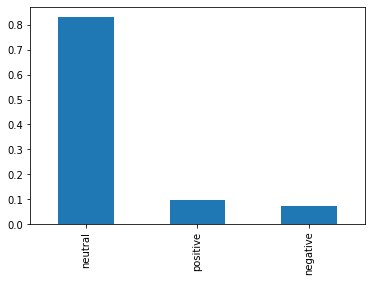

In [20]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [21]:
vax['date'] = pd.to_datetime(vax['date'], errors='coerce').dt.date
vax['Sentiment'] = vax['Sentiment'].replace(['negative', 'neutral', 'positive'],
                                            [-1, 0, 1])
# vax['Sentiment'] = vax['Sentiment'].map({'negative': -1, 'nrutral': 0, 'positive': 1})

In [40]:
# vax.head()

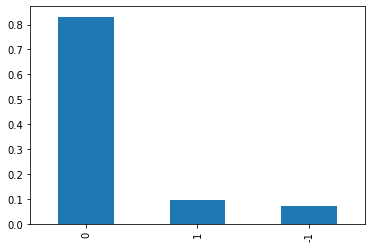

In [22]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [23]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik', 'johnson']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine'] = all_vax
sentiments = list()

#### Vaccine with Time

In [24]:
def time_variance(vacc) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    
    fg, axs = plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs, x='date', y='Sentiment', data=temp)
    axs.set_xlabel("Time", size=16)
    axs.set_ylabel("Sentiment", size=16)
    axs.set_title("Variance of Sentiment wrt Time", size=24)
    axs.grid()

#### Mean overall sentiment

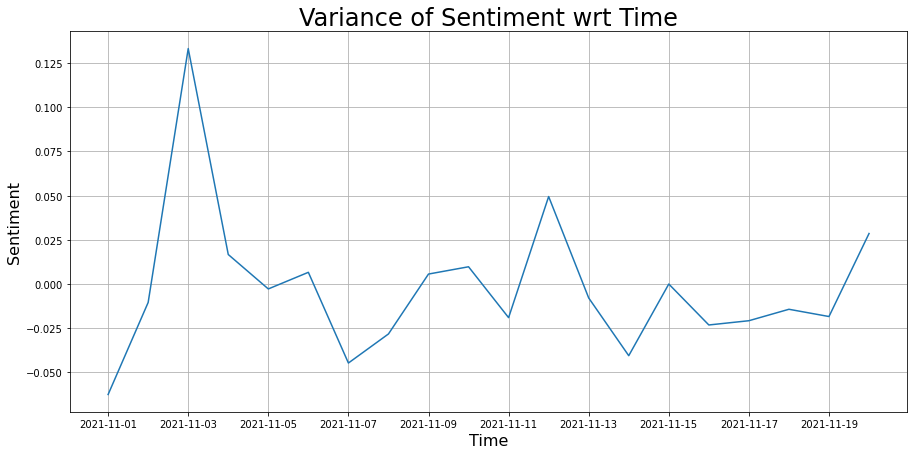

In [25]:
time_variance('all')

#### Moderna, Pfizer, JJ, COVAXIN, Sinopharm, Sinovac, AZ, Sputnik

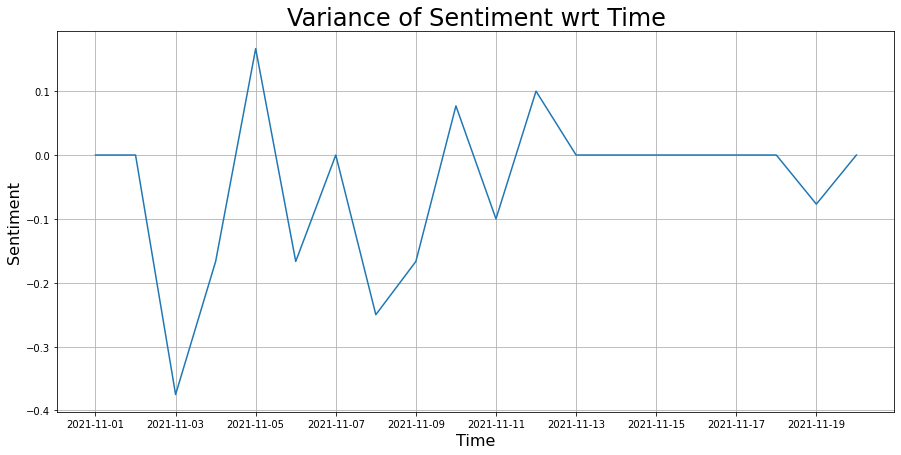

In [26]:
time_variance('moderna')

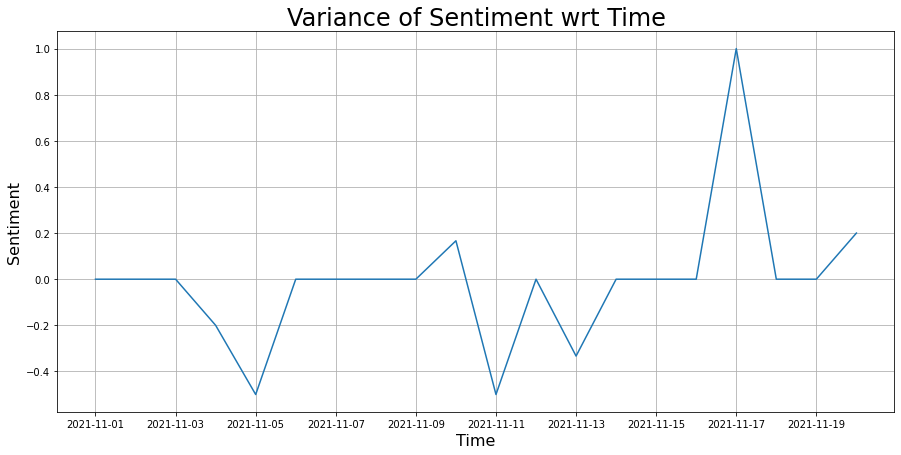

In [27]:
time_variance('pfizer')

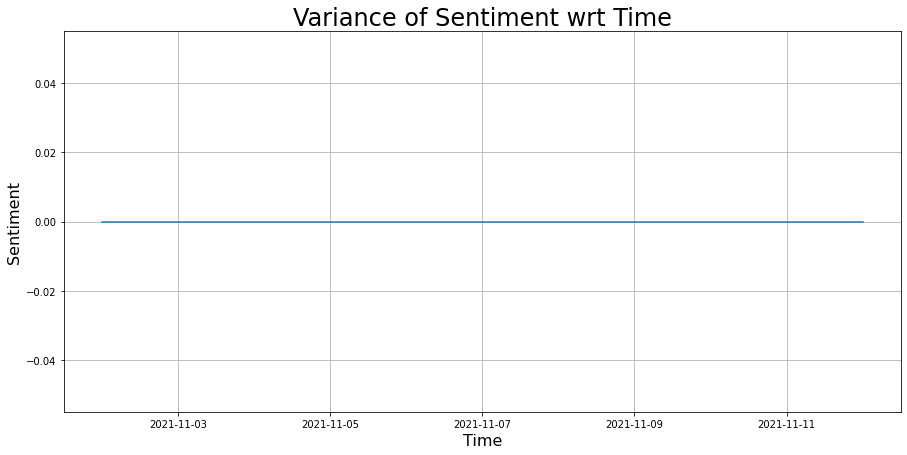

In [28]:
time_variance('johnson')

In [48]:
# time_variance('covaxin')
# time_variance('sinovac')
# time_variance('sinopharm')
# time_variance('biontech')
# time_variance('oxford')
# time_variance('astrazeneca')
# time_variance('sputnik')

### Comparison among Countries

In [29]:
def time_variance_country(country) :
    count = vax[vax['user_location'].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title(f"Variance of Sentiment wrt Time",size=24)
    axs.grid()

In [50]:
# time_variance_country('india')

In [51]:
# time_variance_country('canada')

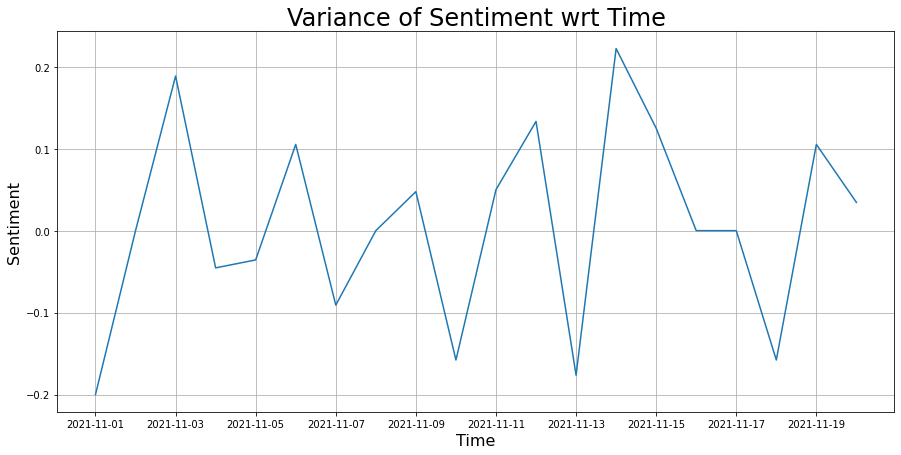

In [30]:
time_variance_country('usa')

The variance of sentiments in different countries seems to be more erratic. The varition might be the politics and economic matters among them.

# WordCloud

In [31]:
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
df_vax_tweets = vax_tweets.to_frame()
text_for_wd = str(df_vax_tweets['text'].values)

In [33]:
text_for_wd_pro = re.sub(r"http\S+", "", text_for_wd)
text_for_wd_pro = re.sub(r'\S+\.com\S+','', text_for_wd_pro)
text_for_wd_pro = re.sub(r'\@\w+','', text_for_wd_pro)
text_for_wd_pro = re.sub("\ ","", text_for_wd_pro)
text_for_wd_pro = re.sub("\'","", text_for_wd_pro)
text_for_wd_pro = re.sub("\\n'","", text_for_wd_pro)

(-0.5, 999.5, 499.5, -0.5)

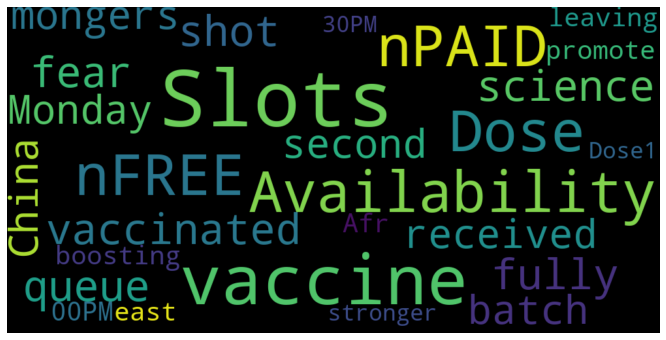

In [34]:
# without hashtags
words = str(vax['text'].values)
word_cloud = WordCloud(width=1000, height=500, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

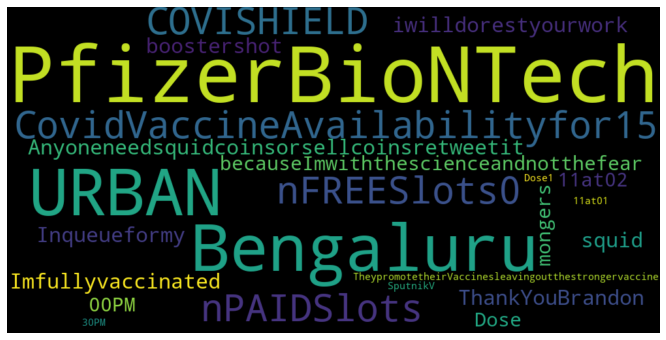

In [35]:
# with hashtags
words = text_for_wd_pro
word_cloud = WordCloud(width=1000, height=500, max_font_size=120).generate(words)
fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

# Topic Modeling

In [36]:
%%capture
!pip3 install pyLDAvis spacy cssselect
!python3 -m spacy download en_core_web_sm

In [37]:
%%capture
import gensim
import gensim.corpora as corpora
import nltk
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
en_stop = set(nltk.corpus.stopwords.words('english'))

In [38]:
# df_vax_tweets.head()

In [39]:
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
df_vax_tweets['text'] = df_vax_tweets['text'].str.replace("\\n'", "", regex=True)

<input>:3: DeprecationWarning: invalid escape sequence \S
<input>:3: DeprecationWarning: invalid escape sequence \S
<ipython-input-39-1f1f1cb858d4>:3: DeprecationWarning: invalid escape sequence \S
  df_vax_tweets['text'] = df_vax_tweets['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)


In [40]:
# df_vax_tweets.head()

In [41]:
df_vax_wks = df_vax_weeks.copy()

In [42]:
# df_vax_wks.head()

In [43]:
# df_vax_wks['text'] = df_vax_wks['text'].str.replace('#[A-Za-z0-9_]+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('#', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('@[A-Za-z0-9_]+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)
df_vax_wks['text'] = df_vax_wks['text'].str.replace("\\n'", "", regex=True)

<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \S
<ipython-input-43-c374bb54aab8>:4: DeprecationWarning: invalid escape sequence \S
  df_vax_wks['text'] = df_vax_wks['text'].str.replace('https?://\S+|www\.\S+', '', regex=True)


In [44]:
# df_vax_wks.head()

In [45]:
df_vax_wks = df_vax_weeks.drop(['user_name', 'user_description', 'user_created', 'user_followers',
                   'user_friends', 'user_favourites', 'source', 'is_retweet', 'id', 'user_location', 'user_verified', 'hashtags', 'retweets', 'favorites'], axis=1)

In [46]:
df_vax_wks['text'] = df_vax_wks['text'].str.replace('#', '', regex=True)

In [47]:
# df_vax_wks.head()

In [48]:
%%capture
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
df_vax_pre = df_vax_wks.copy()
nlp = spacy.load('en_core_web_sm')

In [49]:
# Preprocessing texts
def make_lower_case(text):
    return text.lower()

def make_tokenize(text):
    return [w for w in text.split()]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
    
def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    text = [w for w in text if not w in stop_words]
    texts = [w for w in text if w.isalpha()]
    texts = " ".join(texts)
    return texts

df_vax_pre['text'] = df_vax_pre['text'].apply(make_lower_case)
df_vax_pre['text'] = df_vax_pre['text'].apply(make_tokenize)
df_vax_pre['text'] = df_vax_pre['text'].apply(lemmatize)
df_vax_pre['text'] = df_vax_pre['text'].apply(remove_stop_words)

In [50]:
# df_vax_pre.head()

In [51]:
%%capture
!pip3 install sentence-transformers
# # !pip3 install umap-learn
# !pip3 install bertopic bertopic[visualization]
!pip3 install bertopic
# # !pip install hdbscan --no-build-isolation --no-binary :all:

In [52]:
# create embeddings with pre-trained model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

sentences = []
for id in range(df_vax_pre.shape[0]):
    sentences.append(df_vax_pre.iloc[id, :]['text'])

embeddings = model.encode(sentences, show_progress_bar=True)

Batches:   0%|          | 0/236 [00:00<?, ?it/s]

In [53]:
%%capture
# might have to restart the runime
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=35, verbose=True)
topics, _ = topic_model.fit_transform(sentences)

In [54]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,2079,-1_covaxin_covid_vaccine_moderna
1,0,383,0_sinovac_sinopharm_dos_million
2,1,355,1_urban_slot_paid_bengaluru
3,2,279,2_moderna_got_first_logo
4,3,272,3_vaccine_vaccinated_moderna_vaccinedeaths
5,4,241,4_approval_covaxin_approve_approved
6,5,236,5_vaccine_covaxin_vaccigen_approved
7,6,235,6_bbmp_bengaluru_availability_free
8,7,187,7_bbmp_slot_paid_bengaluru
9,8,173,8_rural_bengaluru_availability_free


In [55]:
topic_nr = freq.iloc[3]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown below

[('moderna', 0.09532597918225337),
 ('got', 0.0345468476692529),
 ('first', 0.0328436888034553),
 ('logo', 0.03170508089780605),
 ('dose', 0.02662945624189213),
 ('marketing', 0.026131730821327612),
 ('want', 0.02318763446951342),
 ('get', 0.019321238910310356),
 ('mine', 0.01866552201523401),
 ('victoriamonet', 0.018455261654809076)]

In [56]:
%%capture
fig = topic_model.visualize_topics()

In [57]:
fig

In [58]:
# output topic graph
fig.write_html("topic_fig.html")

In [59]:
scores_map = topic_model.visualize_barchart(); scores_map

In [60]:
# output scores map of keywords
scores_map.write_html('scores_fig.html')

In [61]:
timestamps = df_vax_wks['date'].to_list()

topics_over_time = topic_model.topics_over_time(docs=sentences, 
                                                topics=topics, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

20it [00:01, 18.97it/s]


In [62]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [63]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20).write_html('topic_over_time.html')

In [64]:
topic_model.get_representative_docs()

{0: ['zimbabwe chose sinovac n sinopharm heard sort noise shld hv chosen british',
  'latest sinopharm delivery nepal direct donation liberation army china',
  'uk add sinopharm approved list'],
 1: ['urban bengaluru covidvaccine availability free slot paid slot covishield',
  'urban bengaluru covidvaccine availability free slot paid slot covishield',
  'urban bengaluru covidvaccine availability free slot paid slot covishield'],
 2: ['moderna', 'moderna', 'moderna'],
 3: ['new vaccine moderna',
  'doe anyone know administering moderna vaccine kumasi',
  'thanks village moderna vaccinated'],
 4: ['well need approve covaxin',
  'covaxin finally get approval',
  'ha steadfastly refused release covaxin even flouting cic order hear'],
 5: ['vaccine good life saver covaxin',
  'main stream medium bed big pharma fails report covaxin traditional vaccine ocgn',
  'story undermining covaxin organized attempt sow doubt promote vaccine hesitancy become'],
 6: ['bbmp bengaluru covidvaccine availabi

In [65]:
#@title Use keywords to find topic
keywords_inputs = 'word_1 word_2' #@param {type: "string"}
topic_model.find_topics(keywords_inputs)

([7, 1, 22, 37, 6],
 [0.3356373186037695,
  0.33144820731613134,
  0.3309686117100035,
  0.3298227041543263,
  0.3277610546873587])

In [66]:
topic_model.visualize_heatmap()

/usr/local/lib/python3.7/dist-packages/plotly/express/_imshow.py:349: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
%%capture
topic_model.save('topic_model')

# Trend Analysis

### Daily vaccinations

In [67]:
datadf_vax_daily = pd.read_csv('country_vaccinations.csv')

In [68]:
# datadf_vax.head()

In [69]:
col_names_daily = ['country', 'people_fully_vaccinated' ,'date', 'daily_vaccinations', 'vaccines']
datadf_vax_col_daily = datadf_vax_daily[col_names_daily]

In [70]:
data_df_usa_daily = datadf_vax_col_daily.loc[datadf_vax_daily['country']=='United States']

In [71]:
# data_df_usa.head()

In [72]:
#@title Time inputs
df_vax_weeks_usa_daily = data_df_usa_daily.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_date = '2021-10-31 23:59:59' #@param {type: "string"}
end_date = '2021-11-20 23:59:59' #@param {type: "string"}
duration = (df_vax_weeks_usa_daily['date'] > start_date) & (df_vax_weeks_usa_daily['date'] <= end_date)

df_vax_weeks_usa_daily = df_vax_weeks_usa_daily.loc[duration]

In [73]:
df_vax_weeks_usa_daily.head()

,country,people_fully_vaccinated,date,daily_vaccinations,vaccines
57758,United States,191747651.0,2021-11-01,1251747.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57759,United States,191926649.0,2021-11-02,1242202.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57760,United States,192108697.0,2021-11-03,1231872.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57761,United States,192290907.0,2021-11-04,1232589.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
57762,United States,192508427.0,2021-11-05,1244801.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


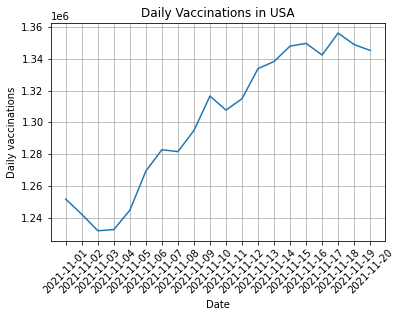

In [74]:
import matplotlib.pyplot as plt
axis_1 = df_vax_weeks_usa_daily['date']
axis_2 = df_vax_weeks_usa_daily['daily_vaccinations']
ano = df_vax_weeks_usa_daily['people_fully_vaccinated']
plt.title("Daily Vaccinations in USA")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_1, axis_2)
plt.grid(True)
plt.show()
# plt.plot(axis_1, ano, '--')

### Daily vaccinations for each brand

In [75]:
# Johnson&Johnson, Moderna, Pfizer/BioNTech
df_brand = pd.read_csv('country_vaccinations_by_manufacturer.csv')

In [76]:
# df_brand.head()

In [77]:
df_brand = df_brand.loc[df_brand['location']=='United States']

In [78]:
#@title Time Inputs
df_brand_weeks = df_brand.copy()
# df_vax_weeks['date'] = pd.to_datetime(df_vax_weeks['date'], format='%Y%m%d', unit='s')
start_time = '2021-10-31 23:59:59' #@param {type:"string"}
end_time = '2021-11-20 23:59:59' #@param {type:"string"}
duration = (df_brand_weeks['date'] > start_date) & (df_brand_weeks['date'] <= end_date)
df_brand_weeks = df_brand_weeks.loc[duration]

In [79]:
# df_brand_weeks.head()

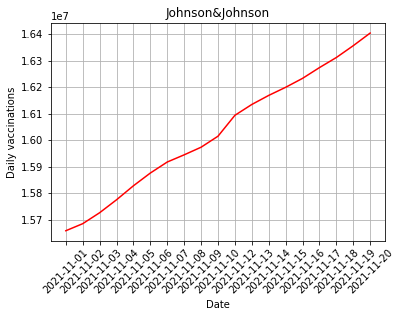

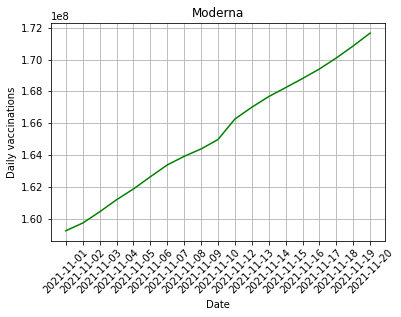

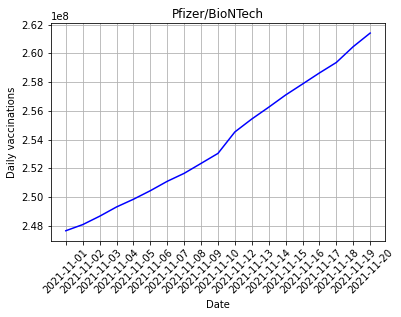

In [80]:
# Johnson&Johnson, Moderna, Pfizer/BioNTech
sel_jj = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Johnson&Johnson']
sel_moderna = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Moderna']
sel_pfizer = df_brand_weeks.loc[df_brand_weeks['vaccine']=='Pfizer/BioNTech']

axis_0 = sel_jj['date']
axis_1 = sel_jj['total_vaccinations']
axis_2 = sel_moderna['total_vaccinations']
axis_3 = sel_pfizer['total_vaccinations']

plt.title("Johnson&Johnson")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_1, 'r', label='Johnson&Johnson')
plt.grid(True)
plt.show()

plt.title("Moderna")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_2, 'g', label='Moderna')
plt.grid(True)
plt.show()

plt.title("Pfizer/BioNTech")
plt.ylabel("Daily vaccinations")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.plot(axis_0, axis_3, 'b', label='Pfizer/BioNTech')
plt.grid(True)
plt.show()

# plt.plot(axis_1, ano, '--')

In [81]:
variance_jj = []
variance_moderna = []
variance_pfizer = []
variance_jj.append(0)
variance_moderna.append(0)
variance_pfizer.append(0)
for id in range(1, sel_jj.shape[0]):
    variance_jj.append(((sel_jj.iloc[id, 3]-sel_jj.iloc[id-1, 3])/sel_jj.iloc[id-1, 3])*100)
for id in range(1, sel_moderna.shape[0]):
    variance_moderna.append(((sel_moderna.iloc[id, 3]-sel_moderna.iloc[id-1, 3])/sel_moderna.iloc[id-1, 3])*100)
for id in range(1, sel_pfizer.shape[0]):
    variance_pfizer.append(((sel_pfizer.iloc[id, 3]-sel_pfizer.iloc[id-1, 3])/sel_pfizer.iloc[id-1, 3])*100)

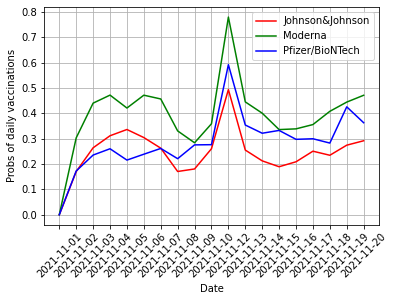

In [82]:
axis_0 = sel_jj['date']
fig, ax = plt.subplots()
plt.xticks(rotation=45)
plt.plot(axis_0, variance_jj, 'r', label='Johnson&Johnson')
plt.plot(axis_0, variance_moderna, 'g', label='Moderna')
plt.plot(axis_0, variance_pfizer, 'b', label='Pfizer/BioNTech')
plt.legend(['Johnson&Johnson', 'Moderna', 'Pfizer/BioNTech'])
plt.ylabel("Probs of daily vaccinations")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### Pie chart for brands

In [83]:
row = sel_jj.shape[0]-1
sel_jj_total = sel_jj.iloc[row, 3]
sel_moderna_total = sel_moderna.iloc[row, 3]
sel_pfizer_total = sel_pfizer.iloc[row, 3]

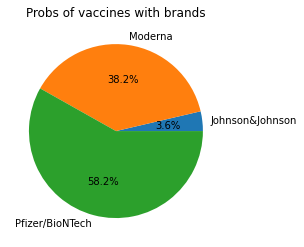

In [84]:
labels = ['Johnson&Johnson', 'Moderna', 'Pfizer/BioNTech']
size = [sel_jj_total, sel_moderna_total, sel_pfizer_total]
plt.pie(size , labels = labels,autopct='%1.1f%%')
plt.title('Probs of vaccines with brands')
plt.show()

# Duration of interest

### Variance of sentiments

In [85]:
def sents_var_plot(vacc) :
    if vacc == 'all':
        vacc = vax
    else:   
        vacc = vax[vax['text'].str.lower().str.contains(vacc)] # vax: store the tweets contain vacc in list
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti = list()
    var = list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment'] = senti
    var.append(0)
    
    for idx in range(1, len(senti)):
        var.append(senti[idx]-senti[idx-1])
 
    axis_0 = temp['date']
    fig, ax = plt.subplots()
    plt.xticks(rotation=45)
    plt.plot(axis_0, var, 'r', label=vacc)

    plt.ylabel("Sentiment Probs of daily vaccinations")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

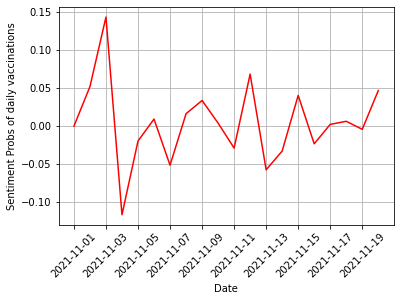

In [86]:
sents_var_plot('all')

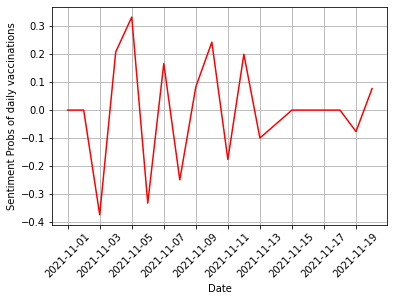

In [87]:
sents_var_plot('moderna')

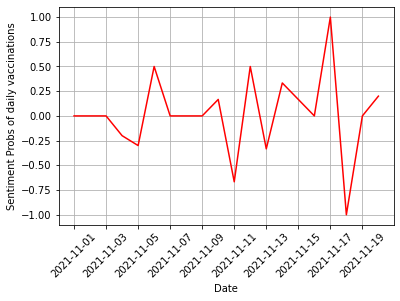

In [88]:
sents_var_plot('pfizer')

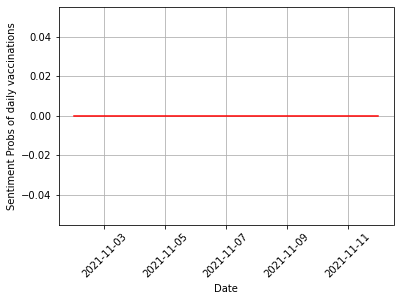

In [89]:
sents_var_plot('johnson')

In [90]:
# automatic reporting system: sentiment
def sents_var_rep(vacc):
    if vacc == 'all':
        vacc = vax
    else :   
        vacc = vax[vax['text'].str.lower().str.contains(vacc)] # vax: store the tweets contain vacc in list
        sentiments.append(vacc.Sentiment.mean())

    temp = pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti = list()
    var = list()
    date_alert = list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())
    temp['Sentiment'] = senti
    var.append(0)

    for idx in range(1, len(senti)):
        var.append(senti[idx]-senti[idx-1])

    var_abs =  [abs(ele) for ele in var]
    var_abs_mean = np.mean(var_abs, axis=0)
    for idx in range(len(var_abs)):
        if var_abs[idx] > var_abs_mean:
            date_alert.append(temp['date'].iloc[idx])
    return date_alert

In [91]:
var_rep_all = sents_var_rep('all')
var_rep_moderna = sents_var_rep('moderna')
var_rep_pfizer = sents_var_rep('pfizer')
var_rep_jj = sents_var_rep('johnson')

In [92]:
# set(var_rep_all).intersection(var_rep_moderna)
# set(var_rep_all).intersection(var_rep_pfizer)

In [93]:
senti_inter = list(set(var_rep_moderna).intersection(var_rep_pfizer))
senti_inter_lst = [str(date) for date in senti_inter]
senti_inter_lst.sort()

In [94]:
senti_inter_lst

['2021-11-05', '2021-11-06', '2021-11-11', '2021-11-12']

### Variance of vaccinations
##### automatic reporting system

In [95]:
# automatic reporting system: sentiment through brands
variance_jj_mean = np.mean(variance_jj, axis=0)
variance_moderna_mean = np.mean(variance_moderna, axis=0)
variance_pfizer_mean = np.mean(variance_pfizer, axis=0)

vax_var_rep_jj = list()
vax_var_rep_moderna = list()
vax_var_rep_pfizer = list()
for idx in range(len(variance_jj)):
    if variance_jj[idx] > variance_jj_mean:
        vax_var_rep_jj.append(sel_jj['date'].iloc[idx])
for idx in range(len(variance_moderna)):
    if variance_moderna[idx] > variance_moderna_mean:
        vax_var_rep_moderna.append(sel_moderna['date'].iloc[idx])
for idx in range(len(variance_jj)):
    if variance_pfizer[idx] > variance_pfizer_mean:
        vax_var_rep_pfizer.append(sel_pfizer['date'].iloc[idx])

In [96]:
set(vax_var_rep_pfizer).intersection(vax_var_rep_moderna)

{'2021-11-12', '2021-11-13', '2021-11-14', '2021-11-19', '2021-11-20'}

In [97]:
# senti_inter_br = list(set(vax_var_rep_pfizer).intersection(vax_var_rep_moderna))
# senti_inter_br_lst = [str(date) for date in senti_inter]
# senti_inter_bar_lst.sort()

In [98]:
# senti_inter_bar_lst

# Multi-Document Summarization

In [99]:
import re
import urllib
from urllib import request
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
import requests.packages.urllib3
requests.packages.urllib3.disable_warnings()

In [100]:
#@title Keywords input
keywords = 'pfizer children' #@param {type: "string"}
keywords = re.sub(' ', '+', keywords)
start_date = '2021-11-03' #@param {type: "string"}
end_date = '2021-11-05' #@param {type: "string"}
search_inputs = f'{keywords}+after%3A{start_date}+before%3A{end_date}'
url = f"https://www.google.com/search?q={search_inputs}&tbm=nws&lr=lang_en&hl=en&sort=date&num=19"
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
}

In [101]:
resp = requests.get(url, headers=headers
                    )
soup = BeautifulSoup(resp.content, "html.parser")
soup_prettify = soup.prettify()
with open('url.html', 'w') as fwrite:
    fwrite.write(soup_prettify)

In [102]:
url_list = []
metas = []
for link in soup.find_all('a'):
    url_list.append(link.get('href'))
for url in url_list:
    if bool(re.findall('google.com', str(url)))==True:
        url_list.remove(url)
regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
for url in url_list:
    if bool(re.findall(regex, str(url)))==True:
        metas.append(url)
for meta in metas:
    if bool(re.findall('policies.google.com', str(meta)))==True:
        metas.remove(meta)

In [103]:
metas

['https://accounts.google.com/ServiceLogin?hl=en&continue=https://www.google.com/search?q%3Dpfizer%2Bchildren%2Bafter%253A2021-11-03%2Bbefore%253A2021-11-05%26tbm%3Dnws%26lr%3Dlang_en%26hl%3Den%26sort%3Ddate%26num%3D19&gae=cb-',
 'https://policies.google.com/privacy?hl=en&utm_source=ucb']

In [103]:
inputs = []
for meta in metas:
    resp = requests.get(meta, headers=headers, verify=False)
    soup = BeautifulSoup(resp.content, "html.parser")
    title = soup.title.string
    title_filtered = re.sub(r'(\s)-(\s)(\w+).+', '', title)
    title_filtered = title_filtered.strip('\r\n\t')
    inputs.append(title_filtered)

In [ ]:
summarizer = pipeline("summarization")
summ=' '.join([str(i) for i in inputs])
summarized = summarizer(summ, min_length=5, max_length=20)
print(summarized)